# Probability of Detection Formula for Kilonovae Associated with BNS Events

## 1. Peak Absolute Magnitude
The peak absolute magnitude $M_{\lambda}(\theta_v)$ of kilonovae as a function of the viewing angle $\theta_v$ is given by:

$$
M_{\lambda}(\theta_v) = 
\begin{cases} 
M_{\lambda, 0} + \Delta M_{\lambda} \cdot \frac{1 - \cos(\theta_v)}{1 - \cos(\theta_0)} + \delta_M, & \text{if } \theta_v \leq \theta_0 \\
M_{\lambda, 0} + \Delta M_{\lambda} + \delta_M, & \text{if } \theta_v > \theta_0
\end{cases}
$$

- **Parameters**:
  - $M_{\lambda, 0}$: Baseline peak absolute magnitude.
  - $\Delta M_{\lambda}$: Change in magnitude due to angular dependence.
  - $\delta_M$: A random fluctuation, either a constant or uniformly distributed within a range.
  - $\theta_0$: Reference viewing angle (e.g., $60^\circ$ or $\pi/3$ radians).

---

## 2. Apparent Magnitude
The apparent magnitude $m_{\lambda}(\theta_v)$ is related to the peak absolute magnitude by:

$$
m_{\lambda}(\theta_v) = M_{\lambda}(\theta_v) + 5 \cdot \log_{10}(d_L) + 25
$$

- **Parameters**:
  - $d_L$: Luminosity distance in megaparsecs (Mpc).
  - $z$: Redshift (used to calculate $d_L$ if not provided).
  - The luminosity distance $d_L$ can be computed using cosmological models.

---

## 3. Probability of Detection
The detection probability $P_{\text{det}}(\theta_v)$ is determined by comparing the apparent magnitude to the detector threshold:

$$
P_{\text{det}}(\theta_v) =
\begin{cases}
1, & \text{if } m_{\lambda}(\theta_v) < \text{detector threshold} \\
0, & \text{otherwise}
\end{cases}
$$

Additionally, the detection probability considers a fraction of kilonovae ($f_{\text{red}}$) lacking a blue component:
- For angles $\theta_v > 60^\circ$:
  - Reduce $P_{\text{det}}$ for bright kilonovae ($m_{\lambda} < 18$).
  - Further adjustments for intermediate and faint sources ($18 \leq m_{\lambda} < 20$ and $m_{\lambda} \geq 20$) based on random sampling weighted by $f_{\text{red}}$.

![[Pasted image 20250120181437.png]]

---

## Example Parameters
- $M_{\lambda, 0} = -16.3$
- $\Delta M_{\lambda} = 4$
- $\theta_0 = 60^\circ$ ($1.047$ radians)
- Detector threshold: $20.5$ (e.g., ZTF threshold).
- Fraction of red kilonovae: $f_{\text{red}} = 0.2$.

This model quantifies the detectability of kilonovae from BNS events by accounting for viewing angle dependence, cosmological distance, and specific detector constraints.


In [1]:
# calling the necessary libraries
from ler.rates import LeR
import numpy as np
# interpolate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

Setting multiprocessing start method to 'fork'


In [2]:
# peak absolute magnitude
def M_lambda_theta_v(
    theta_v,
    theta_0 = 1.0471975511965976, # 60 degrees
    M_lambda_0=-16.3, 
    Delta_M_lambda=4, 
    delta_M=[1,1],
):  
    if isinstance(delta_M, list):
        delta_M = np.random.uniform(*delta_M)
    elif isinstance(delta_M, float):
        pass
    else:
        raise ValueError("delta_M must be either a list or a float")

    result = np.zeros_like(theta_v)

    for i, theta in enumerate(theta_v):
        if theta<=theta_0:
            result[i] = M_lambda_0 + Delta_M_lambda * ((1 - np.cos(theta)) / (1 - np.cos(theta_0))) + delta_M
        else:
            result[i] = M_lambda_0 + Delta_M_lambda + delta_M

    return result

# apparent magnitude
def m_lambda_theta_v(
    theta_v,
    dl = None, # in Mpc
    z = None,
    theta_0 = 1.0471975511965976, # 60 degrees
    M_lambda_0=-16.3, 
    Delta_M_lambda=4, 
    delta_M=[1,1],
):

    if dl is None and z is None:
        raise ValueError("Either dl or z must be provided")
    elif dl is None:
        dl = cosmo.luminosity_distance(z).value
    M_lambda = M_lambda_theta_v(theta_v, theta_0, M_lambda_0, Delta_M_lambda, delta_M)

    return M_lambda + 5 * np.log10(dl) + 25

# pdet
def pdet_kne(
    theta_v, # in rad
    dl = None, # in Mpc
    z = None,
    theta_0 = 1.0471975511965976, # 60 degrees
    M_lambda_0=-16.3, 
    Delta_M_lambda=4, 
    delta_M=[1,1],
    detector_threshold=20.5, # ZTF threshold
    #detector_threshold=25.5, # ZTF threshold
    f_red = 0.2, # fraction of kilonovae that lacks blue component
):
    len_ = len(theta_v)
    m_lambda = m_lambda_theta_v(theta_v, dl, z, theta_0, M_lambda_0, Delta_M_lambda, delta_M)


    # pdet
    pdet = np.zeros_like(m_lambda)
    pdet[m_lambda < detector_threshold] = 1

    if (f_red!=0.0) and (f_red is not None) and (isinstance(f_red, float)):
        # choose f_red fraction and set pdet to 0
        # draw random number between 0 and 1 for each element in pdet
        gr_60_deg = np.rad2deg(theta_v) > 60
    
        idx_below_18 = (m_lambda < 18) & gr_60_deg & (pdet==1) & (np.random.uniform(0, 1, len_) < f_red)
        idx_between_18_20 = (m_lambda >= 18) & (m_lambda < 20) & gr_60_deg & (pdet==1) & (np.random.uniform(0, 1, len_) < f_red)
        idx_above_20 = (m_lambda >= 20) & gr_60_deg

        # print(np.sum(idx_below_18))
        # print(np.sum(idx_between_18_20))
        # print(np.sum(idx_above_20))
        
        if np.sum(idx_above_20) != 0:
            num_above_20 = np.sum(idx_above_20)
            fraction_above_20 = num_above_20 / len(m_lambda)
            idx_above_20 &= (np.random.uniform(0, 1, len_) < f_red*(1+1/fraction_above_20)) & (pdet==1)
            pdet[idx_above_20] = 0

        # print(np.sum(idx_above_20))

        pdet[idx_below_18] = 0
        pdet[idx_between_18_20] = 0
    
    return pdet

In [3]:
def pdet_calculator(gw_param_dict):
        """
        """

        # get the angle and distance from the dictionary
        angle = np.degrees(gw_param_dict['theta_jn'])
        if 'luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['luminosity_distance']
        elif 'effective_luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['effective_luminosity_distance']

        # calculate the probability of detection
        pdet = pdet_kne(np.radians(angle), dl=distance)
        pdet_net_dict = dict(pdet_net=pdet)

        # return the pdet
        return pdet_net_dict

In [34]:
# test pdet_calculator
size = 100000
#theta_jn = np.arccos((np.random.uniform(0, 1, size=size) - 0.5) * 2)
theta_jn = np.random.uniform(0, np.pi/2, size=size)
luminosity_distance = np.random.uniform(10, 500, size=size)
gw_param_dict = dict(theta_jn=theta_jn, luminosity_distance=luminosity_distance)
pdet_arr = pdet_calculator(gw_param_dict)

In [35]:
np.sum(pdet_arr['pdet_net'])

10915.0

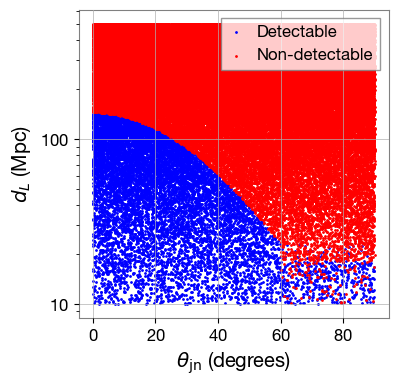

In [41]:
# plot detectable and non-detectable events
plt.figure(figsize=(4, 4))
detectable_idx = pdet_arr['pdet_net'] == 1
plt.scatter(np.degrees(theta_jn)[detectable_idx], luminosity_distance[detectable_idx], c='b', s=1, label='Detectable')
plt.scatter(np.degrees(theta_jn)[~detectable_idx], luminosity_distance[~detectable_idx], c='r', s=1, label='Non-detectable')
plt.yscale('log')
plt.xlabel(r'$\theta_{\rm jn}$ (degrees)')
plt.ylabel(r'$d_L$ (Mpc)')
plt.legend(loc='upper right')
plt.show()

In [6]:
# gw170817, 40 Mpc, 30 degrees
gw_param_dict = dict(theta_jn=np.array([np.radians(30.0)]), luminosity_distance=np.array([40.0]))
pdet_arr = pdet_calculator(gw_param_dict)
pdet_arr

{'pdet_net': array([1.])}

## MEDIAN

In [9]:
ler.z_to_luminosity_distance(np.array([1]))

array([6607.65761177])

In [8]:
ler.luminosity_distance_to_z(np.array([400]))

array([0.08763011])

In [7]:
ler = LeR(
    npool=8,
    verbose=True,
    #z_max=0.08763011, # dl = 400
    #z_max=1.0,
    z_max=0.1,
    pdet_finder=pdet_calculator,
    source_priors= {'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018'},
    source_priors_params= {'merger_rate_density': {'R0': 10.55e-08, 'b2': 1.6, 'b3': 2.0, 'b4': 30}},
    event_type='BNS',
    mtot_max=51,
    psds={'L1':'../rates_o4/o4_psd.txt', 'H1':'../rates_o4/o4_psd.txt'},
    snr_type="interpolation",
    lens_functions =  {
        'strong_lensing_condition': 'rjs_with_cross_section_sis',
        'optical_depth': 'optical_depth_epl_shear_hemanta',
        'optical_depth_params': {'interpolated_cross_section': False},
        'param_sampler_type': 'sample_all_routine_sis',
        },
)


Initializing LeR class...


Initializing LensGalaxyParameterDistribution class...


Initializing OpticalDepth class

z_to_Dc interpolator will be generated at ./interpolator_pickle/z_to_Dc/z_to_Dc_4.pickle
Dc_to_z interpolator will be generated at ./interpolator_pickle/Dc_to_z/Dc_to_z_4.pickle
angular_diameter_distance interpolator will be generated at ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_4.pickle
differential_comoving_volume interpolator will be generated at ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_8.pickle
velocity_dispersion_ewoud interpolator will be generated at ./interpolator_pickle/velocity_dispersion/velocity_dispersion_ewoud_4.pickle
Using pre-gererated axis ratio rayleigh pdf coefficients...
axis_ratio_rayleigh interpolator will be loaded from ./interpolator_pickle/axis_ratio/axis_ratio_rayleigh_0.pickle
axis_ratio sampler: CPUDispatcher(<function OpticalDepth.axis_ratio_rayleigh.<locals>.sampler at 

### Unlensed events

In [10]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=10000,
    batch_size=200000,
    resume=False,
    trim_to_size=False,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_kne_median.json",
    meta_data_file="meta_unlensed_kne_median.json",
)
# 0.07078762653227513

removing ./ler_data/n_unlensed_params_detectable_kne_median.json and ./ler_data/meta_unlensed_kne_median.json if they exist
collected number of detectable events =  0
given detectability_condition == 'pdet'
collected number of detectable events =  338
total number of events =  200000
total rate (yr^-1): 0.05709715775572437
given detectability_condition == 'pdet'
collected number of detectable events =  677
total number of events =  400000
total rate (yr^-1): 0.0571816210068423
given detectability_condition == 'pdet'
collected number of detectable events =  1061
total number of events =  600000
total rate (yr^-1): 0.05974367295741967
given detectability_condition == 'pdet'
collected number of detectable events =  1406
total number of events =  800000
total rate (yr^-1): 0.05937766553590862
given detectability_condition == 'pdet'
collected number of detectable events =  1746
total number of events =  1000000
total rate (yr^-1): 0.05898913458076612
given detectability_condition == 'pdet'


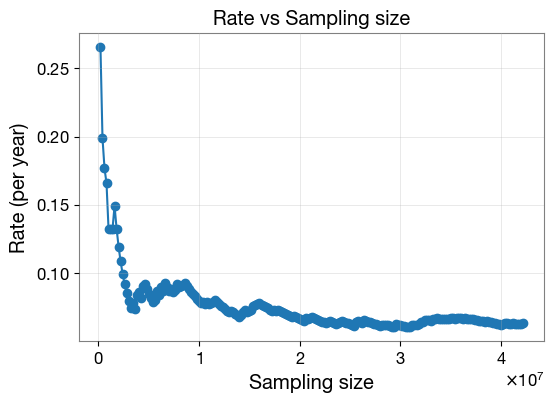

In [20]:
# getting data from json
meta_data= get_param_from_json("./ler_data/meta_unlensed_kne_median.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [21]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 3e6)[0]
# take average 
grb_rate_unlensed_median = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', grb_rate_unlensed_median)

Unlensed GRB Rate (per year) = 0.07042046072760116


### Lensed events

In [11]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=1000,
    batch_size=100000,
    # snr_threshold=[8.0,8.0],
    # num_img=[1,1],
    resume=False,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_kne_median.json",
    meta_data_file="meta_lensed_kne_median.json",
)
# unlensed 9000000
# given detectability_condition == pdet
# collected number of detectable events =  1
# total number of events =  3500000
# total rate (yr^-1): 0.00018062264436835248

removing ./ler_data/n_lensed_params_detectable_kne_median.json and ./ler_data/meta_lensed_kne_median.json if they exist
collected number of detectable events =  0


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 60.51it/s]


given detectability_condition == pdet
collected number of detectable events =  307
total number of events =  100000
total rate (yr^-1): 2.9529179517578523e-08


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 49.73it/s]


given detectability_condition == pdet
collected number of detectable events =  604
total number of events =  200000
total rate (yr^-1): 2.9048248255077245e-08


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.84it/s]


given detectability_condition == pdet
collected number of detectable events =  891
total number of events =  300000
total rate (yr^-1): 2.8567316992575963e-08


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 22.38it/s]


given detectability_condition == pdet
collected number of detectable events =  1203
total number of events =  400000
total rate (yr^-1): 2.8928015439451924e-08
storing detectable lensed params in ./ler_data/n_lensed_params_detectable_kne_median.json
storing meta data in ./ler_data/meta_lensed_kne_median.json

 trmming final result to size=1000
collected number of detectable events =  1000
total number of events =  332502.0
total lensed event rate (yr^-1): 2.8928022237537148e-08


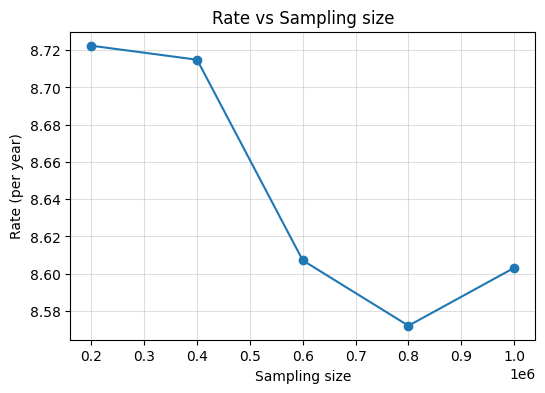

In [23]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb_median.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [12]:
0.059730/2.8928022237537148e-08

2064779.9393106815

In [13]:
ler = LeR(
    npool=8,
    verbose=True,
    #z_max=0.08763011, # dl = 400
    #z_max=1.0,
    z_max=5,
    source_priors= {'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018'},
    source_priors_params= {'merger_rate_density': {'R0': 10.55e-08, 'b2': 1.6, 'b3': 2.0, 'b4': 30}},
    event_type='BNS',
    mtot_max=51,
    psds={'L1':'../rates_o4/o4_psd.txt', 'H1':'../rates_o4/o4_psd.txt'},
    snr_type="interpolation",
    lens_functions =  {
        'strong_lensing_condition': 'rjs_with_cross_section_sis',
        'optical_depth': 'optical_depth_epl_shear_hemanta',
        'optical_depth_params': {'interpolated_cross_section': False},
        'param_sampler_type': 'sample_all_routine_sis',
        },
)


Initializing LeR class...


Initializing LensGalaxyParameterDistribution class...


Initializing OpticalDepth class

z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_1.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_1.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_1.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_pickle/velocity_dispersion/velocity_dispersion_ewoud_1.pickle
Using pre-gererated axis ratio rayleigh pdf coefficients...
axis_ratio_rayleigh interpolator will be loaded from ./interpolator_pickle/axis_ratio/axis_ratio_rayleigh_0.pickle
axis_ratio sampler: CPUDispatcher(<function OpticalDepth.axis_ratio_rayleigh.<locals>.sampler at 0x33d

interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


 # LeR set up params:
npool = 4,
z_min = 0.0,
z_max = 5,
event_type = 'BNS',
size = 100000,
batch_size = 50000,
cosmology = LambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Ode0=0.7, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None),
snr_finder = <bound method GWSNR.snr of <gwsnr.gwsnr.GWSNR object at 0x1081b0760>>,
json_file_names = {'ler_params': 'ler_params.json', 'unlensed_param': 'unlensed_param.json', 'unlensed_param_detectable': 'unlensed_param_detectable.json', 'lensed_param': 'lensed_param.json', 'lensed_param_detectable': 'lensed_param_detectable.json'},
interpolator_directory = './interpolator_pickle',
ler_directory = './ler_data',

 # LeR also takes CBCSourceParameterDistribution class params as kwargs, as follows:
source_priors = {'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018', 'source_frame_masses': 'binary_masses_BNS_bimodal', 'zs': 'sample_source_redshift', 'geocent_time': 'sampler_uniform', 'ra': 'sampler_uniform', 'dec': 'sampler_cosine', 'phase': 'sampler_uni

In [14]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=5000,
    batch_size=200000,
    snr_threshold=10.0,
    resume=True,
    trim_to_size=True,
    output_jsonfile="n_unlensed_params_detectable_gw_super2.json",
    meta_data_file="meta_unlensed_gw_super2.json",
)

collected number of detectable events =  0
given detectability_condition == 'step_function'
collected number of detectable events =  3
total number of events =  200000
total rate (yr^-1): 6.197821088811555
given detectability_condition == 'step_function'
collected number of detectable events =  3
total number of events =  400000
total rate (yr^-1): 3.0989105444057774
given detectability_condition == 'step_function'
collected number of detectable events =  7
total number of events =  600000
total rate (yr^-1): 4.820527513520099
given detectability_condition == 'step_function'
collected number of detectable events =  10
total number of events =  800000
total rate (yr^-1): 5.164850907342962
given detectability_condition == 'step_function'
collected number of detectable events =  15
total number of events =  1000000
total rate (yr^-1): 6.197821088811555
given detectability_condition == 'step_function'
collected number of detectable events =  21
total number of events =  1200000
total rate 

SystemError: CPUDispatcher(<function get_interpolated_snr at 0x30fc4ca60>) returned a result with an exception set

In [16]:
gw_rate_unlensed = 4.473779307064679

In [15]:
unlensed_param_detectable = get_param_from_json('./ler_data/n_unlensed_params_detectable_gw_super2.json')
unlensed_kne_pdet = pdet_calculator(unlensed_param_detectable)

In [17]:
# number of detectable events in terms of GRB pdet out of already detected events in term of GW snr
print(f"Number of unlensed detectable events in terms of GRB pdet is {np.sum(unlensed_kne_pdet['pdet_net']==1)} \nout of {len(unlensed_kne_pdet['pdet_net'])} events that are already detected in terms of GW snr\n")

print(f"if the rate of detectable unlensed GWs is {gw_rate_unlensed}, \nthen the rate of detectable GRBs is {gw_rate_unlensed*np.sum(unlensed_kne_pdet['pdet_net']==1)/len(unlensed_kne_pdet['pdet_net'])}\n")

print(f"ratio (unlensed detectable GWs)/(unlensed detectable GRBs) = {len(unlensed_kne_pdet['pdet_net'])/np.sum(unlensed_kne_pdet['pdet_net']==1)}")

Number of unlensed detectable events in terms of GRB pdet is 10 
out of 615 events that are already detected in terms of GW snr

if the rate of detectable unlensed GWs is 4.473779307064679, 
then the rate of detectable GRBs is 0.07274437897666144

ratio (unlensed detectable GWs)/(unlensed detectable GRBs) = 61.5


In [38]:
0.073/4.47 * 21.07

0.3440961968680089

In [18]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=1000,
    batch_size=200000,
    snr_threshold=[8.0,8.0],
    num_img=[1,1],
    resume=True,
    output_jsonfile="n_lensed_params_detectable_gw_super2.json",
    meta_data_file="meta_lensed_gw_super2.json",
)

collected number of detectable events =  0


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 77.86it/s]


given detectability_condition == step_function
collected number of detectable events =  3
total number of events =  200000
total rate (yr^-1): 0.009482688829338505


100%|██████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 102.30it/s]


given detectability_condition == step_function
collected number of detectable events =  7
total number of events =  400000
total rate (yr^-1): 0.011063136967561588


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.80it/s]


given detectability_condition == step_function
collected number of detectable events =  10
total number of events =  600000
total rate (yr^-1): 0.010536320921487229


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 71.75it/s]


given detectability_condition == step_function
collected number of detectable events =  14
total number of events =  800000
total rate (yr^-1): 0.011063136967561588


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 61.97it/s]


given detectability_condition == step_function
collected number of detectable events =  17
total number of events =  1000000
total rate (yr^-1): 0.010747047339916972


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 73.66it/s]


given detectability_condition == step_function
collected number of detectable events =  20
total number of events =  1200000
total rate (yr^-1): 0.010536320921487229


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 43.70it/s]


given detectability_condition == step_function
collected number of detectable events =  21
total number of events =  1400000
total rate (yr^-1): 0.009482688829338505


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 32.45it/s]


given detectability_condition == step_function
collected number of detectable events =  22
total number of events =  1600000
total rate (yr^-1): 0.008692464760226962


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.12it/s]


given detectability_condition == step_function
collected number of detectable events =  24
total number of events =  1800000
total rate (yr^-1): 0.008429056737189782


 84%|████████████████████████████████████████████▍        | 167762/200000 [00:37<00:07, 4440.40it/s]


KeyboardInterrupt: 

In [20]:
gw_rate_lensed = 0.009482688829338505

In [21]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_gw_super2.json")
# get pdet for the lensed events
pdet_lensed,_ = ler.get_lensed_snrs(
    lensed_param=lensed_param_detectable,
    list_of_detectors=['L1','H1','V1'],
    pdet_calculator=pdet_calculator,
)

# only detectable GRBs
num_ =  np.sum(np.sum(pdet_lensed['pdet_net']==1, axis=1)>=2)

In [22]:
# number of detectable events in terms of GRB pdet out of already detected events in term of GW snr
print(f"Number of lensed detectable events in terms of GRB pdet is {num_} \nout of {len(pdet_lensed['pdet_net'])} events that are already detected in terms of GW snr\n")

print(f"if the rate of detectable lensed GWs is {gw_rate_lensed}, \nthen the rate of detectable GRBs is {gw_rate_lensed*num_/len(pdet_lensed['pdet_net'])}\n")

print(f"ratio (lensed detectable GWs)/(lensed detectable GRBs) = {len(pdet_lensed['pdet_net'])/num_}")

Number of lensed detectable events in terms of GRB pdet is 0 
out of 24 events that are already detected in terms of GW snr

if the rate of detectable lensed GWs is 0.009482688829338505, 
then the rate of detectable GRBs is 0.0

ratio (lensed detectable GWs)/(lensed detectable GRBs) = inf


In [23]:
4.473779307064679/0.008429056737189782

530.756814973845